### Creation of context

In [1]:
# Initialize the spark environment
import pyspark
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Preparation of data

In [2]:
dataPath = "admissions.csv"
df = sqlc.read.format("csv")\
  .option("header","true")\
  .option("inferSchema", "true")\
  .load(dataPath)
df = df.withColumnRenamed("Serial No.", "SerialNumber")
df = df.withColumnRenamed("GRE Score", "GRE")
df = df.withColumnRenamed("TOEFL Score", "TOEFL")
df = df.withColumnRenamed("University Rating", "UniversityRating")
df = df.withColumnRenamed("LOR ", "LOR")
df = df.withColumnRenamed("Chance of Admit ", "ChanceOfAdmit")

Writing data into parquet:

In [4]:
parquetPath = '/home/ec2-user/SageMaker/khg8mh/parquet_data'
df.write.parquet(parquetPath)

Getting data back from parquet:

In [3]:
df = sqlc.read.parquet(parquetPath)

### MLlib based analysis

In [4]:
# Data pre-processing before building a model
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

assembler = VectorAssembler(inputCols=['GRE','TOEFL','UniversityRating','SOP','LOR','CGPA','Research'], outputCol="features")
stages = [assembler]

label_stringIdx = StringIndexer(inputCol="ChanceOfAdmit", outputCol="label")
stages += [label_stringIdx]

partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(df)
preppedDataDF = pipelineModel.transform(df)

selectedcols = ["label", "features"] + df.columns
dataset = preppedDataDF.select(selectedcols)

In [5]:
# train test split
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)

In [21]:
# Logistic regression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainingData)

# Predict on testing data
predictions = lrModel.transform(testData)

In [22]:
# Calulate area under ROC curve
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Area under ROC curve
evaluator.evaluate(predictions)

0.396551724137931

### Visualization of results

In [23]:
predictions.show()

+-----+--------------------+------------+---+-----+----------------+---+---+----+--------+-------------+--------------------+--------------------+----------+
|label|            features|SerialNumber|GRE|TOEFL|UniversityRating|SOP|LOR|CGPA|Research|ChanceOfAdmit|       rawPrediction|         probability|prediction|
+-----+--------------------+------------+---+-----+----------------+---+---+----+--------+-------------+--------------------+--------------------+----------+
|  0.0|[303.0,100.0,2.0,...|         353|303|  100|               2|3.0|3.5|8.06|       1|         0.64|[3.30940623913666...|[0.02458952481225...|      10.0|
|  0.0|[312.0,98.0,1.0,3...|         294|312|   98|               1|3.5|3.0|8.18|       1|         0.64|[3.76103823058983...|[0.03456527524996...|       1.0|
|  0.0|[312.0,105.0,2.0,...|         102|312|  105|               2|2.5|3.0|8.12|       0|         0.64|[4.94235096783516...|[0.09613489056191...|       0.0|
|  0.0|[312.0,107.0,3.0,...|          21|312|  107| 

In [24]:
# dislpay() function doesn't show output in jupyter notebook for some reason
display(lrModel, preppedDataDF, 'ROC')

LogisticRegression_4af0abfdc64f806c933b

DataFrame[SerialNumber: int, GRE: int, TOEFL: int, UniversityRating: int, SOP: double, LOR: double, CGPA: double, Research: int, ChanceOfAdmit: double, features: vector, label: double]

'ROC'

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


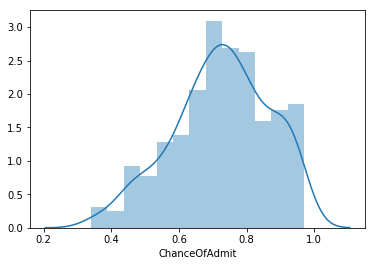

In [63]:
plot_df = df.toPandas()
sns.distplot(plot_df.ChanceOfAdmit)